In [5]:
%pylab inline
%load_ext autoreload
%autoreload 2

import copy
import argparse
import numpy as np
import lsst.daf.persistence   as dafPersist
import lsst.afw.coord         as afwCoord
import lsst.afw.image         as afwImage
import lsst.afw.geom          as afwGeom
import lsst.afw.table         as afwTable

# Matplotlib default settings
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = 12, 10
mpl.rcParams['xtick.major.size'] = 8.0
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 4.0
mpl.rcParams['xtick.minor.width'] = 1.5
mpl.rcParams['ytick.major.size'] = 8.0
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.size'] = 4.0
mpl.rcParams['ytick.minor.width'] = 1.5
mpl.rc('axes', linewidth=2)

import cubehelix  # Cubehelix color scheme from https://github.com/jradavenport/cubehelix
ccmap = cubehelix.cmap(start=0.5, rot=-0.8, minSat=1.2, maxSat=1.2, 
                               minLight=0., maxLight=1., gamma=1.0)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
rootDir = '/lustre/Subaru/SSP/rerun/yasuda/SSP3.4.1_20141224/'
filter  = 'HSC-I'

## Get cutout image

In [7]:
# Get the skymap 
butler = dafPersist.Butler(rootDir)
skyMap = butler.get("deepCoadd_skyMap", immediate=True)

In [8]:
# Example galaxy: 
# From redmapper 
wideRa  = 133.65253
wideDec = 0.64257544
sizeCut = 1000    # Extreme
sizeExp = (sizeCut * 2 + 1) ** 2

In [9]:
def getCircleRaDec(ra, dec, size):

    # Get a small but representative set of (RA, DEC) that describe a circle
    # region around the central input coordinate

    # Convert the size from pixel unit to degress
    sizeDegree = (size * 0.168) / 3600.0
    # representative set of polar angles
    angles = np.array([0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0])
    phi = np.array(angles * np.pi / 180.0)
    
    # Get the (Ra, Dec) coordinates of these points 
    raList  = ra  + sizeDegree * np.cos(phi)
    decList = dec + sizeDegree * np.sin(phi)
    
    # Also include the center 
    raList  = np.append(raList,  ra)
    decList = np.append(decList, dec)

    return raList, decList

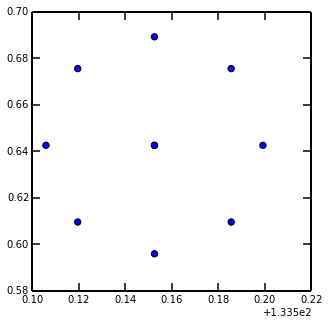

In [10]:
raList, decList = getCircleRaDec(wideRa, wideDec, sizeCut)

fig = plt.figure(figsize=[5,5])
ax  = plt.gca()

ax.scatter(wideRa, wideDec, s=40.0, c='r')
ax.scatter(raList, decList, s=40.0, c='b')

In [11]:
# Try list match 
points = map(lambda x, y: afwGeom.Point2D(x, y), raList, decList)
coord = map(lambda x: afwCoord.IcrsCoord(x), points)
matches = skyMap.findClosestTractPatchList(coord)
# Number of matched Tracts 
nTract = len(matches)
print nTract
tractInfo, patchInfo = matches[0]

1


In [17]:
def getTractPatchList(matches):

    tract = []
    patch = []

    for match in matches:
        tractInfo, patchInfo = match
        tractId = tractInfo.getId()
        for patchItem in patchInfo:
            tract.append(tractId)
            patch.append("%d,%d" % patchItem.getIndex())

    return tract, patch

In [18]:
tracts, patches = getTractPatchList(matches)

In [20]:
patches

['2,3', '2,4', '3,3', '3,4']

In [14]:
# Number of matched Patches
nPatch = 0 
for tt in np.arange(nTract): 
    nPatch += len(matches[tt][1])
print nPatch

4


In [12]:
for tract, patch in matches: 
    tractId = tract.getId() 
    patchId = "%d,%d" % patch[0].getIndex()
    print "Find (Tract, Patch): %d, %s" % (tractId, patchId)

Find (Tract, Patch): 9559, 2,3


In [13]:
coadd = butler.get("deepCoadd", tract=tractId, patch=patchId, filter='HSC-I', immediate=True)

In [14]:
wcs = coadd.getWcs()
center = afwCoord.IcrsCoord(afwGeom.Point2D(wideRa, wideDec))

In [15]:
pixel = wcs.skyToPixel(center)
pixel = afwGeom.Point2I(pixel)

In [16]:
bbox = afwGeom.Box2I(pixel, pixel)
bbox.grow(sizeCut)

In [17]:
print bbox.getBeginX(), bbox.getBeginY()

10159 14830


In [18]:
xCBefore = map(lambda x: x.getX(), bbox.getCorners())
yCBefore = map(lambda x: x.getY(), bbox.getCorners())

In [19]:
coaddBBox = coadd.getBBox(afwImage.PARENT)

xCcoadd = map(lambda x: x.getX(), coaddBBox.getCorners())
yCcoadd = map(lambda x: x.getY(), coaddBBox.getCorners())

In [20]:
bbox.clip(coadd.getBBox(afwImage.PARENT))

xCAfter = map(lambda x: x.getX(), bbox.getCorners())
yCAfter = map(lambda x: x.getY(), bbox.getCorners())

print bbox.getBeginX(), bbox.getBeginY()

10159 14830


NameError: name 'minXafter' is not defined

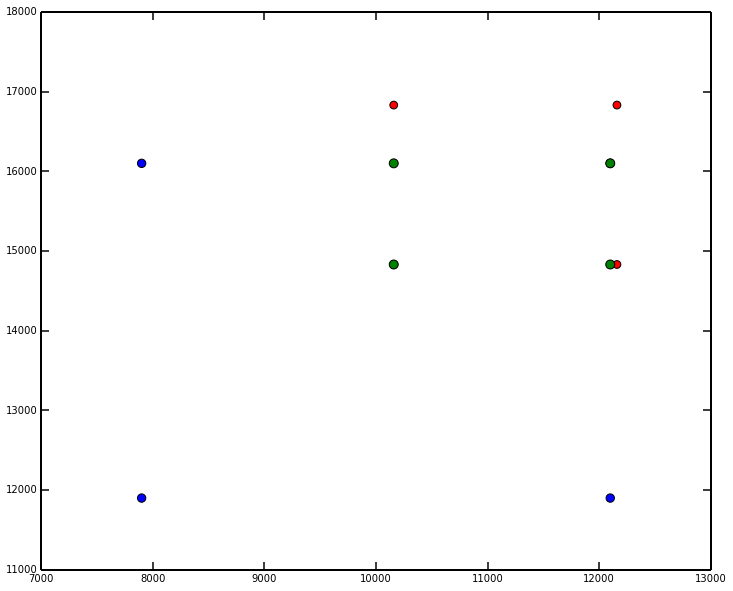

In [21]:
plt.scatter(xCBefore, yCBefore, s=60, c='r')
plt.scatter(xCcoadd,  yCcoadd,  s=70, c='b')
plt.scatter(xCAfter,  yCAfter,  s=80, c='g')

cenXNew = (sizeCut * 2 + 1)/2.0 - (minXafter - minXbefore)
cenYNew = (sizeCut * 2 + 1)/2.0 - (minYafter - minYbefore)
print cenXNew, cenYNew

In [19]:
subImage = afwImage.ExposureF(coadd, bbox, afwImage.PARENT).getMaskedImage().getArrays()

NameError: name 'cenXNew' is not defined

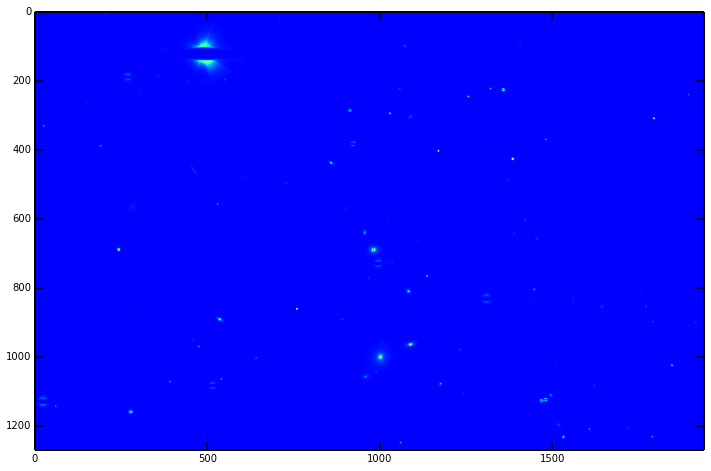

In [20]:
plt.imshow(subImage[0])
plt.scatter(cenXNew, cenYNew, s=100, c='r', alpha=0.5)

## Make a RGB color image

In [607]:
import lsst.afw.display.rgb as afwRgb

images = {}
wcs    = {}
filters = ['HSC-G', 'HSC-R', 'HSC-I']

for i in [0,1,2]: 
    
    exp = butler.get('deepCoadd', immediate=True, tract=tractId, 
                    patch=patchId, filter=filters[i])
    expWcs = exp.getWcs()
    
    sub = afwImage.ExposureF(exp, bbox, afwImage.PARENT)
    subWcs = sub.getWcs()
    
    images[i] = sub
    wcs[i] = subWcs 

In [608]:
# 
raDec = afwCoord.Coord(wideRa*afwGeom.degrees, wideDec*afwGeom.degrees)

B = images[0].getMaskedImage().getImage() 
G = images[1].getMaskedImage().getImage()
R = images[2].getMaskedImage().getImage() 

cenB = wcs[0].skyToPixel(raDec)
print cenB
cenG = wcs[1].skyToPixel(raDec)
cenR = wcs[2].skyToPixel(raDec)

xy0B = B.getXY0()
print xy0B

(11159, 15830)
(10159, 14830)


In [611]:
Bheight = B.getHeight()

In [610]:
min = 0.001
max = 0.8
range = (max - min)
Q = 6
imgRgb = afwRgb.makeRGB(R, G, B, min=min, range=range, Q=Q, saturatedPixelValue=None)

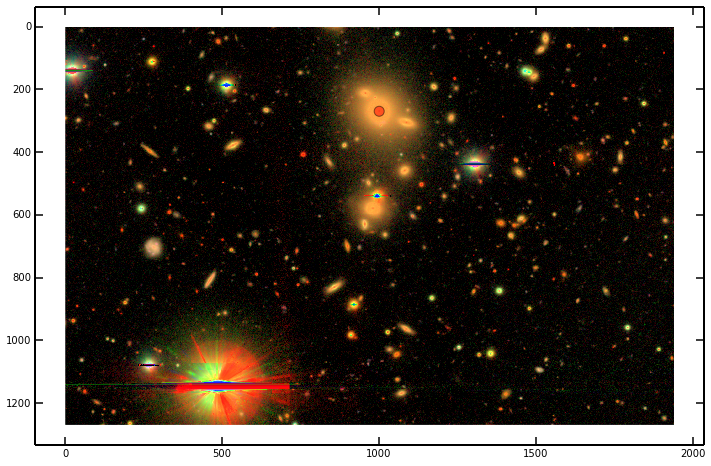

In [612]:
plt.imshow(imgRgb, interpolation='none')
plt.scatter(cenXNew, Bheight - cenYNew, s=100, c='r', alpha=0.5)

In [362]:
def isHscFilter(filter, full=True):

    if full:
        hscFilters = ['HSC-G', 'HSC-R', 'HSC-I', 'HSC-Z', 'HSC-Y']
    else:
        hscFilters = ['g', 'r', 'i', 'z', 'y']

    return (filter in hscFilters)

filt = ['HSC-G', 'HSC-R', 'HSC-I'] 

if len(filt) is not 3:
    raise Exception("Have to be three filters!")
elif not (isHscFilter(filt[0]) & isHscFilter(filt[1]) &
          isHscFilter(filt[2])):
    raise Exception("Not all filters are valid !")
else: 
    print "Ok!"

Ok!


In [367]:
print B.getXY0()
print cenB

(24479, 31124)
(24679, 31324)


## Find all objects around the cutout center using the source catalog

In [289]:
cat = butler.get('deepCoadd_forced_src', tract=tractId, patch=patchId, 
                 filter=filter, immediate=True)

In [290]:
srcRa  = np.array(map(lambda x: x.get('coord').getRa().asDegrees(),  cat))
srcDec = np.array(map(lambda x: x.get('coord').getDec().asDegrees(), cat))

In [262]:
sizeDeg = (200.0 * 0.168 / 3600.0)

In [310]:
indMatch = ((srcRa > (wideRa - sizeDeg)) & (srcRa < (wideRa + sizeDeg)) & 
            (srcDec > (wideDec - sizeDeg)) & (srcDec < (wideDec + sizeDeg)))

/home/song/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from IPython.kernel.zmq import kernelapp as app
/home/song/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from IPython.kernel.zmq import kernelapp as app


In [311]:
indMatch

array([False, False, False, ..., False, False, False], dtype=bool)

In [312]:
subCat = cat.subset(indMatch)

In [313]:
len(subCat)

350

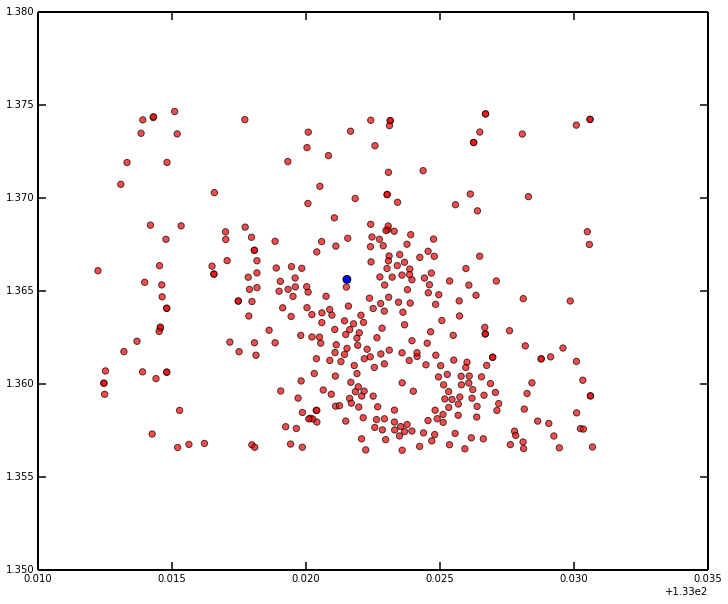

In [314]:
plt.scatter(srcRa[indMatch], srcDec[indMatch], s=40, c='r', alpha=0.7)
plt.scatter(wideRa, wideDec, s=60, c='b')

## Compare two overlapped images

In [23]:
coadd1 = butler.get("deepCoadd", tract=9559, patch='2,3', filter='HSC-I', immediate=True)
coadd2 = butler.get("deepCoadd", tract=9559, patch='2,4', filter='HSC-I', immediate=True)

In [24]:
oriX1, oriY1 = coadd1.getXY0().getX(), coadd1.getXY0().getY()
oriX2, oriY2 = coadd2.getXY0().getX(), coadd2.getXY0().getY()
dimX1, dimY1 = coadd1.getWidth(), coadd1.getHeight()
dimX2, dimY2 = coadd2.getWidth(), coadd2.getHeight()

In [25]:
cornerX1 = [oriX1, oriX1, oriX1 + dimX1, oriX1 + dimX1]
cornerX2 = [oriX2, oriX2, oriX2 + dimX2, oriX2 + dimX2]
cornerY1 = [oriY1, oriY1 + dimY1, oriY1 + dimY1, oriY1]
cornerY2 = [oriY2, oriY2 + dimY2, oriY2 + dimY2, oriY2]

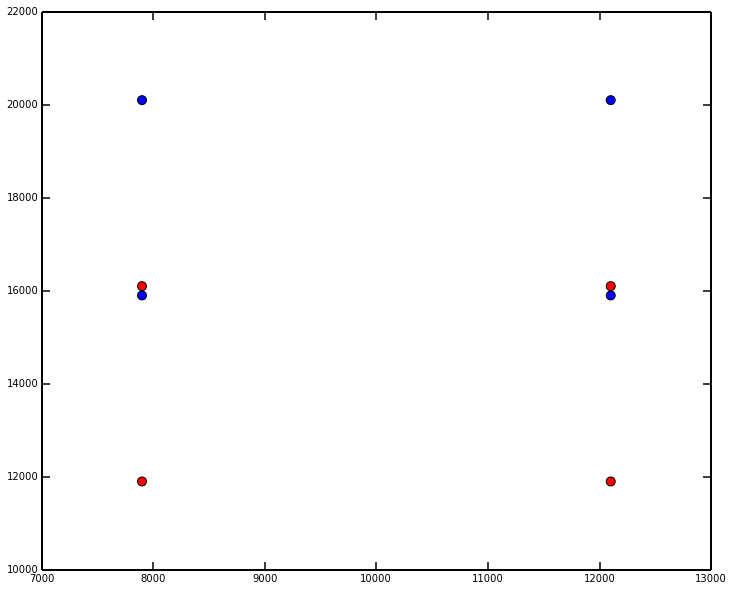

In [26]:
plt.scatter(cornerX1, cornerY1, s=80, c='r')
plt.scatter(cornerX2, cornerY2, s=80, c='b')

In [27]:
from shapely.geometry import Polygon

In [28]:
poly1 = Polygon([(cornerX1[0], cornerY1[0]), (cornerX1[1], cornerY1[1]), 
                 (cornerX1[2], cornerY1[2]), (cornerX1[3], cornerY1[3])])
poly2 = Polygon([(cornerX2[0], cornerY2[0]), (cornerX2[1], cornerY2[1]), 
                 (cornerX2[2], cornerY2[2]), (cornerX2[3], cornerY2[3])])

In [29]:
inter1 = poly1.intersection(poly2)
inter2 = poly2.intersection(poly1)

In [30]:
indXmin1 = inter1.bounds[0] - oriX1
indXmax1 = inter1.bounds[2] - oriX1
indYmin1 = inter1.bounds[1] - oriY1
indYmax1 = inter1.bounds[3] - oriY1

In [31]:
indXmin2 = inter2.bounds[0] - oriX2
indXmax2 = inter2.bounds[2] - oriX2
indYmin2 = inter2.bounds[1] - oriY2
indYmax2 = inter2.bounds[3] - oriY2

In [32]:
indXmin1, indXmax1, indYmin1, indYmax1

(0.0, 4200.0, 4000.0, 4200.0)

In [33]:
indXmin2, indXmax2, indYmin2, indYmax2

(0.0, 4200.0, 0.0, 200.0)

In [34]:
exp1 = coadd1.getMaskedImage().getArrays()
img1 = exp1[0]
msk1 = exp1[1] 
var1 = exp1[2] 

exp2 = coadd2.getMaskedImage().getArrays()
img2 = exp2[0]
msk2 = exp2[1] 
var2 = exp2[2] 

In [35]:
over1  = img1[indYmin1:indYmax1, indXmin1:indXmax1]
over1v = var1[indYmin1:indYmax1, indXmin1:indXmax1]
over1m = msk1[indYmin1:indYmax1, indXmin1:indXmax1]

over1.shape

(200, 4200)

In [36]:
over2  = img2[indYmin2:indYmax2, indXmin2:indXmax2]
over2v = var2[indYmin2:indYmax2, indXmin2:indXmax2]
over2m = msk2[indYmin2:indYmax2, indXmin2:indXmax2]

over2.shape

(200, 4200)

In [37]:
# 
raDec = afwCoord.Coord(wideRa*afwGeom.degrees, wideDec*afwGeom.degrees)
wcs1 = coadd1.getWcs()
wcs2 = coadd2.getWcs()

gal1 = wcs1.skyToPixel(raDec)
gal2 = wcs2.skyToPixel(raDec)

In [38]:
galX1, galY1 = gal1.getX() - oriX1, gal1.getY() - oriY1
galX2, galY2 = gal2.getX() - oriX2, gal2.getY() - oriY2

In [39]:
def zscale(img, contrast=0.25, samples=500):

    ravel = img.ravel()
    if len(ravel) > samples:
        imsort = numpy.sort(numpy.random.choice(ravel, size=samples))
    else:
        imsort = numpy.sort(ravel)

    n = len(imsort)
    idx = numpy.arange(n)

    med = imsort[n/2]
    w = 0.25
    i_lo, i_hi = int((0.5-w)*n), int((0.5+w)*n)
    p = numpy.polyfit(idx[i_lo:i_hi], imsort[i_lo:i_hi], 1)
    slope, intercept = p

    z1 = med - (slope/contrast)*(n/2-n*w)
    z2 = med + (slope/contrast)*(n/2-n*w)

    return z1, z2

In [ ]:
fig, axes = pyplot.subplots(3, 1, sharex=True, sharey=True, figsize=(18,6))

vmin, vmax = zscale(over1)
axes[0].imshow(over1, interpolation='none', vmin=vmin, vmax=vmax, 
              cmap=ccmap)
axes[0].text(0.8, 0.86, 'mean value = %13.10f' % np.mean(over1), horizontalalignment='center',
             verticalalignment='center', transform=ax.transAxes, fontsize=20)
#axes[0].text(0.8, 0.46, 'std. = %13.10f' % np.std(over1), horizontalalignment='center',
#             verticalalignment='center', transform=ax.transAxes, fontsize=20)
#axes[0].text(0.4, 0.35, 'min = %13.10f' % np.min(over1), horizontalalignment='center',
#             verticalalignment='center', transform=ax.transAxes, fontsize=20)
#axes[0].text(0.8, 0.35,  'max = %13.10f' % np.max(over1), horizontalalignment='center',
#             verticalalignment='center', transform=ax.transAxes, fontsize=20)

vmin, vmax = zscale(over2)
axes[1].imshow(over2, interpolation='none', vmin=vmin, vmax=vmax,
              cmap=ccmap)
#axes[1].text(0.4, 0.24, 'mean value = %13.10f' % np.mean(over2), horizontalalignment='center',
#             verticalalignment='center', transform=ax.transAxes, fontsize=20)
#axes[1].text(0.8, 0.24, 'std. = %13.10f' % np.std(over2), horizontalalignment='center',
#             verticalalignment='center', transform=ax.transAxes, fontsize=20)
#axes[1].text(0.4, 0.13, 'min = %13.10f' % np.min(over2), horizontalalignment='center',
#             verticalalignment='center', transform=ax.transAxes, fontsize=20)
#axes[1].text(0.8, 0.13,  'max = %13.10f' % np.max(over2), horizontalalignment='center',
#             verticalalignment='center', transform=ax.transAxes, fontsize=20)

diff = (over1 - over2)
vmin, vmax = zscale(diff)
axes[2].imshow(diff, interpolation='none', vmin=vmin, vmax=vmax, 
              cmap=ccmap)
axes[2].text(0.4, 0.02, 'mean value = %13.10f' % np.mean(diff), horizontalalignment='center',
             verticalalignment='center', transform=ax.transAxes, fontsize=20)
#axes[2].text(0.8, 0.02, 'std. = %13.10f' % np.std(diff), horizontalalignment='center',
#             verticalalignment='center', transform=ax.transAxes, fontsize=20)
#axes[2].text(0.4, -0.09, 'min = %13.10f' % np.min(diff), horizontalalignment='center',
#             verticalalignment='center', transform=ax.transAxes, fontsize=20)
#axes[2].text(0.8, -0.09,  'max = %13.10f' % np.max(diff), horizontalalignment='center',
#             verticalalignment='center', transform=ax.transAxes, fontsize=20)

fig.subplots_adjust(bottom=0.1, right=0.95, top=0.99, wspace=0.01, hspace=0.2)

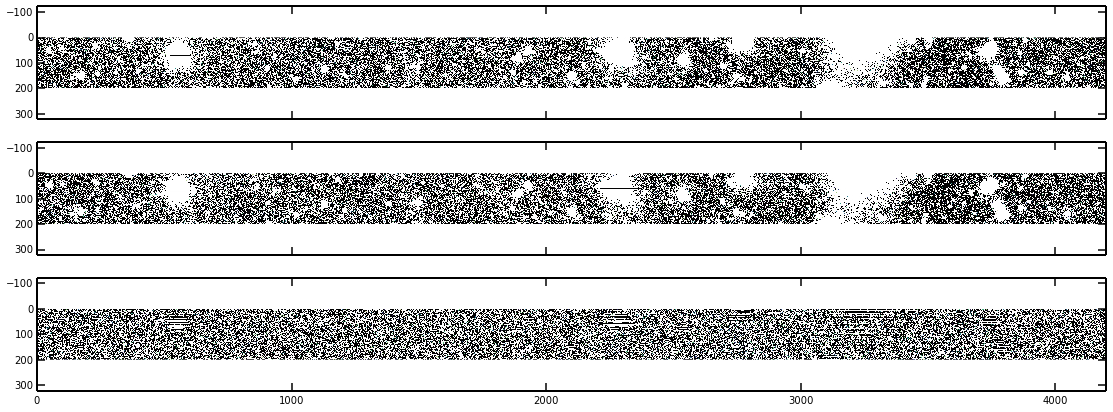

In [42]:
fig, axes = pyplot.subplots(3, 1, sharex=True, sharey=True, figsize=(18,6))

vmin, vmax = zscale(over1v)
axes[0].imshow(over1, interpolation='none', vmin=vmin, vmax=vmax, 
              cmap=ccmap)

vmin, vmax = zscale(over2v)
axes[1].imshow(over2, interpolation='none', vmin=vmin, vmax=vmax,
              cmap=ccmap)

vdiff = (over1v - over2v)
vmin, vmax = zscale(vdiff)
axes[2].imshow(diff, interpolation='none', vmin=vmin, vmax=vmax,
              cmap=ccmap)

fig.subplots_adjust(bottom=0.1, right=0.95, top=0.99, wspace=0.01, hspace=0.2)

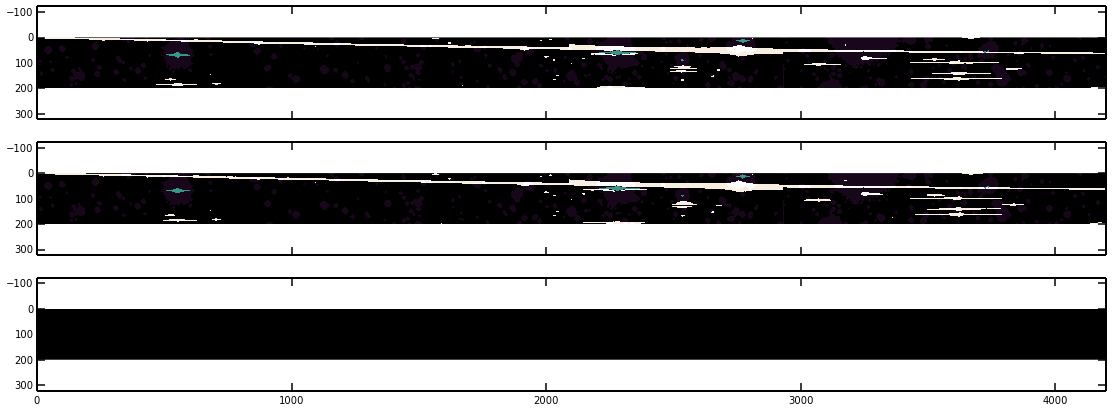

In [44]:
fig, axes = pyplot.subplots(3, 1, sharex=True, sharey=True, figsize=(18,6))

axes[0].imshow(over1m, interpolation='none', cmap=ccmap)

axes[1].imshow(over2m, interpolation='none', cmap=ccmap)

mdiff = (over1m - over2m)
axes[2].imshow(mdiff, interpolation='none', cmap=ccmap)

fig.subplots_adjust(bottom=0.1, right=0.95, top=0.99, wspace=0.01, hspace=0.2)

In [95]:
print galX1, galY1 
print galX2, galY2

3259.42016108 3930.07827272
3259.42016108 -69.9217272768


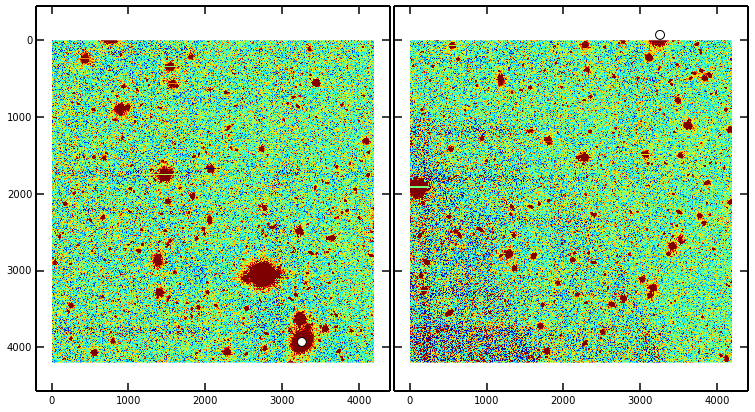

In [94]:
fig, axes = pyplot.subplots(1, 2, sharex=True, sharey=True, figsize=(12,6))

vmin, vmax = zscale(img1)
axes[0].imshow(img1, interpolation='none', vmin=vmin, vmax=vmax)
axes[0].scatter(galX1, galY1, s=80, c='w')

vmin, vmax = zscale(img2)
axes[1].imshow(img2, interpolation='none', vmin=vmin, vmax=vmax)
axes[1].scatter(galX2, galY2, s=80, c='w')

fig.subplots_adjust(bottom=0.1, right=0.95, top=0.99, wspace=0.01)

## WCS Comparison

In [2]:
rootDir = '/lustre/Subaru/SSP/rerun/yasuda/SSP3.4.1_cosmos_setWeight/'
tract   = 0
patch   = '7,1' 
filter  = 'HSC-R'
file    = rootDir + 'deepCoadd/' + filter + '/' + str(tract) + '/' + patch + '.fits'
import os
os.path.isfile(file)

True

In [3]:
butler = dafPersist.Butler(rootDir)
coadd = butler.get("deepCoadd", tract=tract, patch=patch, filter=filter, immediate=True)
pipeWcs = coadd.getWcs()

In [45]:
bbox = coadd.getBBox(afwImage.PARENT)

In [48]:
bbox.getBeginX(), bbox.getBeginY()

(7900, 7900)

In [44]:
## Image WCS
pipeWcs.getCDMatrix()

array([[ -4.66666667e-05,   0.00000000e+00],
       [  0.00000000e+00,   4.66666667e-05]])

In [58]:
coord = pipeWcs.pixelToSky(7909, 7909)
coord.getLongitude().asDegrees(), coord.getLatitude().asDegrees()

(31.84384037017038, -7.1648277435459375)

In [4]:
from astropy.io import fits 
from astropy    import wcs as apyWcs

hduList = fits.open(file)
header = hduList[1].header
imgWcs = apyWcs.WCS(header)
hduList.close()

In [42]:
imgWcs.wcs_pix2world([[10, 10]], 1)

array([[ 31.84384037,  -7.16482774]])

## Extra NoData Test

In [6]:
rootDir = '/lustre/Subaru/SSP/rerun/yasuda/SSP3.4.1_20141224/'
tract   = 9452
patch   = '0,0' 
filter  = 'HSC-Y'
file    = rootDir + 'deepCoadd/' + filter + '/' + str(tract) + '/' + patch + '.fits'
import os
os.path.isfile(file)

True

In [2]:
import coaddPatchNoData as cpn 

In [ ]:
cpn.coaddPatchNoData(rootDir, tract, patch, filter, prefix='test', 
                     savePNG=True, verbose=True, clobber=True)

## Reading Fits Image: /lustre/Subaru/SSP/rerun/yasuda/SSP3.4.1_20141224/deepCoadd/HSC-Y/9452/0,0.fits
### 354 contours have been detected


### 85 regions are useful

In [7]:
# Shapely related imports 
from shapely.geometry import MultiPolygon, Point
from shapely.geometry import Polygon, LineString
from shapely          import wkb 
from shapely.ops      import cascaded_union 

from scipy import ndimage
from skimage.measure import find_contours, approximate_polygon    

In [8]:
butler = dafPersist.Butler(rootDir)
calExp = butler.get('deepCoadd', tract=tract, patch=patch, filter=filter, immediate=True)
mskImg = calExp.getMaskedImage().getMask() 
noData = copy.deepcopy(mskImg)
noData &= noData.getPlaneBitMask('NO_DATA')
noDataArr = noData.getArray()
noDataArr = np.lib.pad(noDataArr, ((1, 1), (1, 1)), 'constant', constant_values=0)  

In [9]:
contoursAll = find_contours(noDataArr, 0)

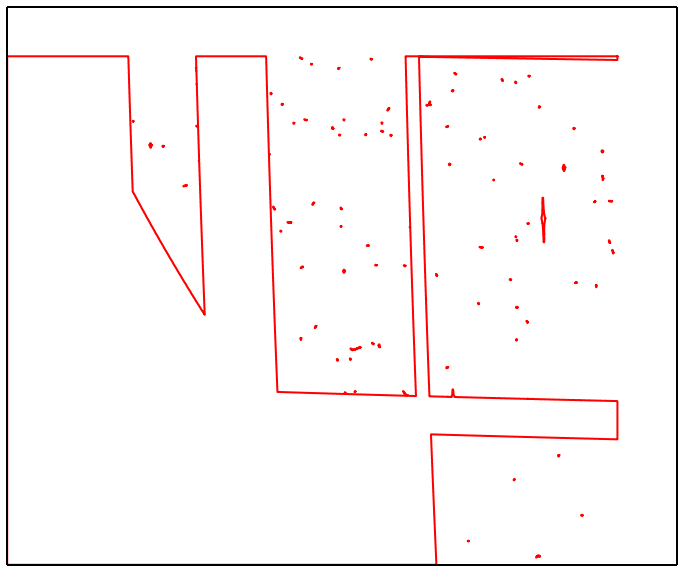

In [11]:
fig, ax = plt.subplots()
#ax.imshow(noDataArr, interpolation='nearest', cmap=plt.cm.gray)
polyList = []
for n, contour in enumerate(contoursAll):
    contourCoords = approximate_polygon(contour, tolerance=4)
    if len(contourCoords) > 3:
        maskLine = LineString(contourCoords)
        if maskLine.is_valid: 
            poly = Polygon(contour)
            polyList.append(poly)
            bounds = poly.boundary
            x, y = bounds.xy
            ax.plot(x, y, linewidth=2, color='r')
        
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [22]:
weird = polyList[43]

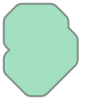

In [26]:
weird.buffer(1)

## Combine NO_DATA Masks for one Tract

In [14]:
import coaddPatchNoData as cpn 
import os

In [26]:
def batchNoDataCombine(tractFile, location='.', big=True, showComb=True, 
                       verbose=True, check=True):

    """ Get the prefix and filter name """
    temp = os.path.basename(tractFile).split('_')
    prefix = temp[0] + '_' + temp[1]
    filter = temp[2]
    
    """ Get the list of tract IDs """
    if not os.path.isfile(tractFile): 
        raise Exception("Can not find the list file: %s" % tractFile)
    tractList = open(tractFile, 'r')
    tractIDs = [int(x) for x in tractList.read().splitlines()]
    tractList.close()
    
    if location[-1] is not '/': 
        location += '/'
    
    """ Go through these tracts """
    """ 
        TODO: In the future, there will be too many tracts in one list 
              pre-select a group tracts that are close together 
    """
    nTract = len(tractIDs)
    print "### Will deal with %d tracts" % nTract
    
    for tractId in tractIDs:
        
        if verbose: 
            print "### Will deal with tract: %d" % tractId 
            
        """ Get the list file names """
        if not big: 
            """ All Region .wkb and .reg list """
            regLis = location + prefix + '_' + str(tractId) + '_' + filter + \
                    '_nodata_all_reg.lis'
            wkbLis = location + prefix + '_' + str(tractId) + '_' + filter + \
                    '_nodata_all_wkb.lis'
            strComb = '_all'
        else: 
            """ Big Region .wkb and .reg list """
            regLis = location + prefix + '_' + str(tractId) + '_' + filter + \
                    '_nodata_big_reg.lis'
            wkbLis = location + prefix + '_' + str(tractId) + '_' + filter + \
                    '_nodata_big_wkb.lis'
            strComb = '_big'
        
        if not os.path.isfile(regLis): 
            raise Exception("Can not find the regLis file: %s" % regLis)
        else: 
            """ Combine the .reg file, it should be easy """
            outReg = prefix + '_' + str(tractId) + '_' + filter + \
                    '_nodata' + strComb + '.reg'
            if verbose: 
                print "### Try to combined their .reg files into %s" % outReg
            cpn.combineRegFiles(regLis, output=outReg, check=check)
            if not os.path.isfile(outReg): 
                raise Exception("Something is wrong with the output .reg file: \
                                %s" % outReg)
            
        if not os.path.isfile(wkbLis): 
            raise Exception("Can not find the wkbLis file: %s" % wkbLis)
        else: 
            """ Combine the .wkb file """
            outWkb = prefix + '_' + str(tractId) + '_' + filter + \
                    '_nodata' + strComb + '.wkb'
            if verbose: 
                print "### Try to combined their .wkb files into %s" % outWkb
            cpn.combineWkbFiles(wkbLis, output=outWkb, check=check)
            if not os.path.isfile(outWkb): 
                raise Exception("Something is wrong with the output .wkb file:\
                                %s" % outWkb)
            else: 
                """ Show the results """
                if showComb:
                    pngTitle = prefix + '_' + str(tractId) + '_' + filter + \
                               '_nodata' + strComb
                    pngName = pngTitle + '.png'
                    cpn.showNoDataMask(outWkb, title=pngTitle, pngName=pngName)

In [27]:
#tractFile = 'ssp341_cosmos_HSC-I_tract.lis'
#location = '/home/song/work/early/ssp341_cosmos_nodata/'

tractFile = 'ssp361_widecos_HSC-I_tract.lis'
location = '/home/song/work/early/ssp361_widecos_nodata/'

In [28]:
batchNoDataCombine(tractFile, location=location, big=False, showComb=True, 
                   verbose=False, check=True)

### Will deal with 29 tracts
### Will combine 71 .reg files
### Will combine 71 .wkb files
### Will combine 72 .reg files
### Will combine 72 .wkb files
### Will combine 81 .reg files
### Will combine 81 .wkb files
### Will combine 72 .reg files
### Will combine 72 .wkb files
### Will combine 78 .reg files
### Will combine 78 .wkb files
### Will combine 34 .reg files
### Will combine 34 .wkb files
### Will combine 81 .reg files
### Will combine 81 .wkb files
### Will combine 45 .reg files
### Will combine 45 .wkb files
### Will combine 34 .reg files
### Will combine 34 .wkb files
### Will combine 46 .reg files
### Will combine 46 .wkb files
### Will combine 42 .reg files
### Will combine 42 .wkb files
### Will combine 81 .reg files
### Will combine 81 .wkb files
### Will combine 80 .reg files
### Will combine 80 .wkb files
### Will combine 72 .reg files
### Will combine 72 .wkb files
### Will combine 81 .reg files
### Will combine 81 .wkb files
### Will combine 72 .reg files
### Will c

In [18]:
import coaddPatchShape as cps

In [19]:
noData = cps.polyReadWkb('ssp341_cosmos_0_HSC-I_nodata_big.wkb')

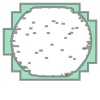

In [20]:
noData

In [24]:
#rootDir = '/lustre/Subaru/SSP/rerun/yasuda/SSP3.4.1_20141224/'
#prefix  = 'ssp341_wide'

rootDir = '/lustre/Subaru/SSP/rerun/yasuda/SSP3.6.1_20150325/'
prefix  = 'ssp361_widecos'

filters  = ['HSC-G', 'HSC-R', 'HSC-I', 'HSC-Z', 'HSC-Y']

In [25]:
for filter in filters: 
    cpn.batchPatchNoData(rootDir, filter=filter, prefix=prefix, 
                           saveList=True, notRun=True)

### Will go through 1447 images !
### There are 23 unique tracts!
### Will go through 1596 images !
### There are 24 unique tracts!
### Will go through 2014 images !
### There are 29 unique tracts!
### Will go through 2014 images !
### There are 29 unique tracts!
### Will go through 1553 images !
### There are 24 unique tracts!
